In [2]:
import findspark
findspark.init()


In [3]:
import os


from pyspark.sql import SparkSession
from pyspark.sql import Row

import collections
import datetime
import pyspark.sql.functions as F

import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns
import squarify
import plotly.offline as py
import plotly_express as px

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA


from IPython.display import Image
warnings.filterwarnings('ignore')
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/Users/ashwinv/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
spark = SparkSession.builder.appName("CovidSK").getOrCreate()

In [5]:
lines = spark.read.csv("/Users/ashwinv/Documents/SEM4/BigData/Project/Datasets/swdata.csv", header=True, mode="DROPMALFORMED")


In [8]:
swdata = lines.select("State","TotalSamples","Negative","Positive")

In [9]:
pd1 = swdata.fillna("null")

pd1.show(10)

+--------------------+------------+--------+--------+
|               State|TotalSamples|Negative|Positive|
+--------------------+------------+--------+--------+
|Andaman and Nicob...|      1403.0|    1210|    12.0|
|Andaman and Nicob...|      2679.0|    null|    27.0|
|Andaman and Nicob...|      2848.0|    null|    33.0|
|Andaman and Nicob...|      3754.0|    null|    33.0|
|Andaman and Nicob...|      6677.0|    null|    33.0|
|Andaman and Nicob...|      6965.0|    null|    33.0|
|Andaman and Nicob...|      7082.0|    null|    33.0|
|Andaman and Nicob...|      7167.0|    null|    33.0|
|Andaman and Nicob...|      7263.0|    null|    33.0|
|Andaman and Nicob...|      7327.0|    null|    33.0|
+--------------------+------------+--------+--------+
only showing top 10 rows



In [10]:
type(pd1)

pyspark.sql.dataframe.DataFrame

In [11]:
pd1.printSchema()

root
 |-- State: string (nullable = false)
 |-- TotalSamples: string (nullable = false)
 |-- Negative: string (nullable = false)
 |-- Positive: string (nullable = false)



In [12]:
def set_df_columns_nullable(spark, df, column_list, nullable=True):
    for struct_field in df.schema:
        if struct_field.name in column_list:
            struct_field.nullable = nullable
    df_mod = spark.createDataFrame(df.rdd, df.schema)
    return df_mod

In [13]:
pd1 = set_df_columns_nullable(spark,pd1,["State","TotalSamples","Negative","Positive"])

In [14]:
pd1.printSchema()

root
 |-- State: string (nullable = true)
 |-- TotalSamples: string (nullable = true)
 |-- Negative: string (nullable = true)
 |-- Positive: string (nullable = true)



In [15]:
from pyspark.sql.types import IntegerType
pd1 = pd1.withColumn("TotalSamples",pd1['TotalSamples'].cast(IntegerType()))
pd1 = pd1.withColumn("Negative",pd1['Negative'].cast(IntegerType()))
pd1 = pd1.withColumn("Positive",pd1['Positive'].cast(IntegerType()))

In [16]:
pd1.printSchema()

root
 |-- State: string (nullable = true)
 |-- TotalSamples: integer (nullable = true)
 |-- Negative: integer (nullable = true)
 |-- Positive: integer (nullable = true)



In [17]:
pd1 = pd1.na.drop()

In [18]:
type(pd1)

pyspark.sql.dataframe.DataFrame

In [19]:
pd1 = pd1.toPandas()

In [22]:
delhi = pd1.loc[pd1["State"]== "Delhi"]
delhi

,State,TotalSamples,Negative,Positive
629,Delhi,9041,7308,576
630,Delhi,9968,8643,720
631,Delhi,11061,9662,903
632,Delhi,11709,10218,1069
633,Delhi,14036,11748,1154
634,Delhi,15032,12283,1510
635,Delhi,16282,13748,1561
636,Delhi,16605,13865,1578
637,Delhi,18784,14692,1640
638,Delhi,21409,16899,1707


In [23]:
DelhiX = delhi[["TotalSamples",'Negative']]
DelhiY = delhi[["Positive"]]

In [24]:
print(DelhiX.shape)
print(DelhiY.shape)

(22, 2)
(22, 1)


In [25]:
Dtrainx, Dtestx = train_test_split(DelhiX, test_size=0.20)
Dtrainy, Dtesty = train_test_split(DelhiY, test_size=0.20)

In [26]:
print(Dtrainx.shape)
print(Dtrainy.shape)
print(Dtestx.shape)
print(Dtesty.shape)

(17, 2)
(17, 1)
(5, 2)
(5, 1)


In [27]:
Dtrainx.head()

,TotalSamples,Negative
630,9968,8643
639,22283,17449
634,15032,12283
648,39911,34145
638,21409,16899


### State wise comparison

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [29]:
Dtrainx

,TotalSamples,Negative
630,9968,8643
639,22283,17449
634,15032,12283
648,39911,34145
638,21409,16899
637,18784,14692
635,16282,13748
640,24387,19393
641,25900,20712
632,11709,10218


In [30]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(Dtrainx, Dtrainy)

Dpredy = regr.predict(Dtestx)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(Dtesty, Dpredy))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(Dtesty, Dpredy))





Coefficients: 
 [[ 0.14441721 -0.13878972]]
Mean squared error: 1447690.55
Coefficient of determination: -0.39


In [41]:
Dtesty.shape

(5, 1)

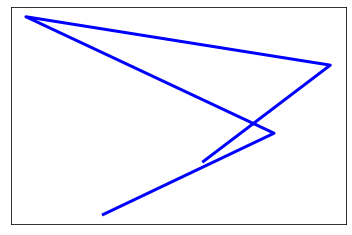

In [42]:
plt.plot(Dtestxy, Dpredy, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()